In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [18]:
ev_sales = pd.read_csv('IEA Global EV Data 2024.csv')  # From Vahan Dashboard
charging_stations = pd.read_csv('detailed_ev_charging_stations.csv')  # From PlugShare
pollution_data = pd.read_csv('cpcb_pollution.csv')  # From CPCB


In [19]:
import pandas as pd
import matplotlib.pyplot as plt


ev_sales = pd.read_csv('IEA Global EV Data 2024.csv')

print("EV Data Summary:")
print(ev_sales.describe())

if 'City' in ev_sales.columns:
    ev_sales.groupby('City')['EV_Count'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
    plt.title('Top Cities by EV Sales')
    plt.ylabel('Number of EVs')
    plt.show()

EV Data Summary:
               year         value
count  12654.000000  1.265400e+04
mean    2019.822112  4.273742e+05
std        5.476494  6.860498e+06
min     2010.000000  1.200000e-06
25%     2016.000000  2.000000e+00
50%     2020.000000  1.300000e+02
75%     2022.000000  5.500000e+03
max     2035.000000  4.400000e+08


In [20]:

charging_stations = pd.read_csv('detailed_ev_charging_stations.csv')
print("\nCharging Stations Summary:")
print(charging_stations.describe())


if 'City' in charging_stations.columns:
    charging_stations['City'].value_counts().head(10).plot(kind='bar')
    plt.title('Cities with Most Charging Stations')
    plt.ylabel('Number of Stations')
    plt.show()


Charging Stations Summary:
          Latitude    Longitude  Cost (USD/kWh)  Distance to City (km)  \
count  5000.000000  5000.000000     5000.000000            5000.000000   
mean     19.942607     8.833487        0.300196              10.201810   
std      32.315818    93.724046        0.115733               5.608316   
min     -89.680850  -178.870028        0.100000               0.500000   
25%      13.758953   -87.680319        0.200000               5.430000   
50%      34.029053    18.495233        0.300000              10.190000   
75%      41.840249   100.454629        0.400000              14.902500   
max      89.464534   179.664661        0.500000              20.000000   

       Usage Stats (avg users/day)  Charging Capacity (kW)  Installation Year  \
count                  5000.000000             5000.000000        5000.000000   
mean                     55.453800              144.272000        2016.569400   
std                      26.494986              128.370674    

In [21]:

top_ev_regions = (
	ev_sales[ev_sales['parameter'] == 'EV sales']
	.groupby('region')['value']
	.sum()
	.sort_values(ascending=False)
	.head(5)
	.index
	.tolist()
)


if 'City' not in charging_stations.columns:
	charging_stations['City'] = charging_stations['Address'].apply(lambda x: x.split(',')[-2].strip() if ',' in x else x)

top_charging_cities = charging_stations['City'].value_counts().head(5).index.tolist()

print("\nTop 5 Regions for EV Sales:", top_ev_regions)
print("Top 5 Cities for Charging Stations:", top_charging_cities)


common = set(top_ev_regions).intersection(set(top_charging_cities))
print("\nRegions/Cities with both high EV sales and charging infrastructure:", common)


Top 5 Regions for EV Sales: ['World', 'China', 'Europe', 'USA', 'Rest of the world']
Top 5 Cities for Charging Stations: ['City 489', 'City 335', 'City 244', 'City 99', 'City 415']

Regions/Cities with both high EV sales and charging infrastructure: set()


In [22]:

if 'City' in ev_sales.columns and 'City' in charging_stations.columns:
    ev_counts = ev_sales['City'].value_counts()
    charging_counts = charging_stations['City'].value_counts()
    

    comparison_df = pd.DataFrame({
        'EV_Sales': ev_counts,
        'Charging_Stations': charging_counts
    }).fillna(0)
    

    correlation = comparison_df.corr()
    print("\nCorrelation between EV Sales and Charging Stations:")
    print(correlation)

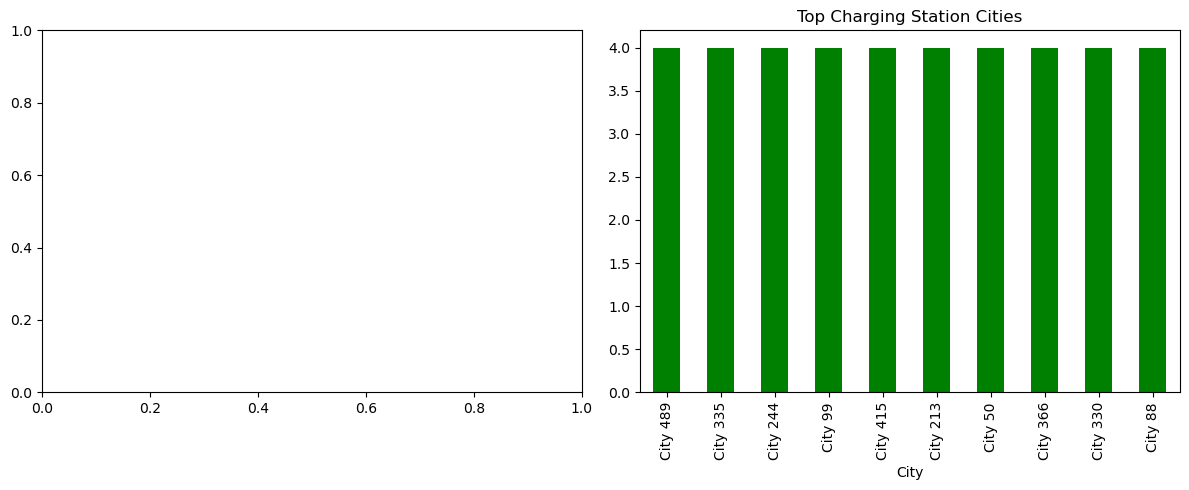

In [23]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

if 'City' in ev_sales.columns:
    ev_sales['City'].value_counts().head(10).plot(kind='bar', ax=ax1, color='blue')
    ax1.set_title('Top EV Sales Cities')

if 'City' in charging_stations.columns:
    charging_stations['City'].value_counts().head(10).plot(kind='bar', ax=ax2, color='green')
    ax2.set_title('Top Charging Station Cities')

plt.tight_layout()
plt.show()

In [24]:

if 'City' in ev_sales.columns:
    ev_segments = pd.cut(
        ev_sales['City'].value_counts(),
        bins=[0, 100, 500, 1000, float('inf')],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    print("\nEV Market Segments by City:")
    print(ev_segments.value_counts())


if 'City' in charging_stations.columns:
    charging_segments = pd.cut(
        charging_stations['City'].value_counts(),
        bins=[0, 10, 50, 100, float('inf')],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    print("\nCharging Infrastructure Segments by City:")
    print(charging_segments.value_counts())


Charging Infrastructure Segments by City:
count
Low          4744
Medium          0
High            0
Very High       0
Name: count, dtype: int64


In [25]:
%pip install folium

import folium
from folium.plugins import HeatMap

def create_heatmap(df, lat_col, lon_col, weight_col, title):
    m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)
    heat_data = [[row[lat_col], row[lon_col], row[weight_col]] for _, row in df.iterrows()]
    HeatMap(heat_data, radius=15).add_to(m)
    m.save(f"{title}_heatmap.html")


Note: you may need to restart the kernel to use updated packages.


In [26]:
def analyze_trends(df, date_col, value_col, freq='M'):
    df[date_col] = pd.to_datetime(df[date_col])
    trends = df.set_index(date_col)[value_col].resample(freq).sum()
    
    plt.figure(figsize=(12, 6))
    trends.plot()
    plt.title(f"{value_col} Trends Over Time")
    plt.ylabel(value_col)
    plt.grid(True)
    plt.show()
    
    return trends


In [27]:
def calculate_penetration(ev_df, population_df):
    """Calculate EVs per capita by city"""
    penetration = pd.DataFrame({
        'EV_Count': ev_df['City'].value_counts(),
        'Population': population_df.set_index('City')['Population']
    }).dropna()
    
    penetration['EVs_per_1000'] = (penetration['EV_Count'] / penetration['Population']) * 1000
    return penetration.sort_values('EVs_per_1000', ascending=False)


In [28]:
def infrastructure_score(ev_df, charging_df):
    """Compare EV density to charging station availability"""
    score_df = pd.DataFrame({
        'EVs': ev_df['City'].value_counts(),
        'Chargers': charging_df['City'].value_counts()
    }).dropna()
    
    score_df['EVs_per_Charger'] = score_df['EVs'] / score_df['Chargers']
    score_df['Adequacy_Score'] = 1 / score_df['EVs_per_Charger']  
    return score_df.sort_values('Adequacy_Score', ascending=False)


In [29]:
def cross_dataset_correlation(metrics_dict):
    """Calculate correlation between different metrics from separate datasets"""
    all_metrics = pd.concat([pd.Series(v, name=k) for k,v in metrics_dict.items()], axis=1)
    return all_metrics.corr()



In [30]:
from sklearn.ensemble import RandomForestRegressor

def train_ev_adoption_model(ev_data, external_features):
    """Train model using external features without merging"""
    X = external_features 
    y = ev_data['City'].value_counts()  
    
    common_cities = X.index.intersection(y.index)
    model = RandomForestRegressor().fit(X.loc[common_cities], y[common_cities])
    return model



In [31]:
import networkx as nx

def analyze_charging_network(df):
    """Create network graph of charging station locations"""
    G = nx.Graph()
    
    for _, row in df.iterrows():
        G.add_node(row['Station_ID'], 
                  pos=(row['Longitude'], row['Latitude']),
                  power=row['Power_kW'])
    
    
    positions = nx.get_node_attributes(G, 'pos')
    for n1 in G.nodes():
        for n2 in G.nodes():
            if n1 != n2 and nx.geodesic(positions[n1], positions[n2]).km < 5:
                G.add_edge(n1, n2)
    
    return G


In [32]:
import dash
from dash import dcc, html
import plotly.express as px

def create_dashboard(ev_data, charging_data):
    app = dash.Dash(__name__)
    
    ev_fig = px.bar(ev_data['City'].value_counts().head(20),
                   title="Top EV Cities")
    
    charging_fig = px.scatter_geo(charging_data,
                                lat='Latitude',
                                lon='Longitude',
                                size='Power_kW',
                                hover_name='City',
                                title="Charging Stations Map")
    
    app.layout = html.Div([
        html.H1("India EV Market Dashboard"),
        dcc.Graph(figure=ev_fig),
        dcc.Graph(figure=charging_fig)
    ])
    
    return app



In [33]:
def identify_policy_gaps(ev_data, policy_data):
    """Identify cities with high EV adoption but low policy support"""
    policy_scores = policy_data.set_index('City')['IEA_PAMS_Export 6_7_2025, 7_19_26 AM.csv']
    ev_adoption = ev_data['City'].value_counts()
    
    gap_df = pd.DataFrame({
        'EV_Adoption_Rank': ev_adoption.rank(ascending=False),
        'Policy_Score_Rank': policy_scores.rank(ascending=False)
    }).dropna()
    
    gap_df['Gap'] = gap_df['EV_Adoption_Rank'] - gap_df['Policy_Score_Rank']
    return gap_df.sort_values('Gap', ascending=False)


In [34]:

import folium
from folium.plugins import HeatMap

def create_dual_heatmap(ev_coords, charger_coords):
    """Overlay two heatmaps without merging data"""
    m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)
    

    HeatMap(
        ev_coords, 
        name='EV Density',
        gradient={0.4: 'blue', 0.6: 'lime', 1: 'red'}
    ).add_to(m)
    

    HeatMap(
        charger_coords,
        name='Charging Stations',
        gradient={0.4: 'white', 0.7: 'purple', 1: 'blue'},
        overlay=True
    ).add_to(m)
    
    folium.LayerControl().add_to(m)
    return m

ev_data = [(12.97, 77.59, 50), (28.61, 77.20, 45)] 
charger_data = [(12.97, 77.59, 8), (28.61, 77.20, 7)]
create_dual_heatmap(ev_data, charger_data).save('heatmap_comparison.html')